In [2]:
!#pip install opencv-python-headless

"#pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Epoch 1/50


c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 631ms/step - loss: 1.6815 - rmse: 1.7964 - val_loss: 3.1614 - val_rmse: 3.1468 - learning_rate: 1.0000e-04
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 498ms/step - loss: 0.1812 - rmse: 0.4274 - val_loss: 4.5869 - val_rmse: 4.5451 - learning_rate: 1.0000e-04
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 581ms/step - loss: 0.1596 - rmse: 0.4223 - val_loss: 1.5307 - val_rmse: 1.3475 - learning_rate: 1.0000e-04
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 438ms/step - loss: 0.1516 - rmse: 0.4189 - val_loss: 0.4389 - val_rmse: 0.5192 - learning_rate: 1.0000e-04
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 544ms/step - loss: 0.1523 - rmse: 0.4170 - val_loss: 0.3146 - val_rmse: 0.4690 - learning_rate: 1.0000e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 426ms/step - loss: 0.1436 - rmse: 0.4163 - val_loss: 0.2765 - val_rmse: 0.4494 - learning_rate: 1.0000e-04
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 647ms/step - loss: 0.1390 - rmse: 0.4140 - val_loss: 0.29

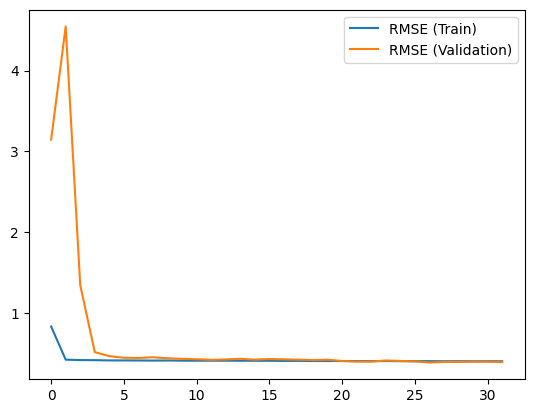

In [1]:
# 📚 Librerías necesarias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ✅ Parámetros Globales
IMG_SIZE = (64, 64)  # Tamaño de las imágenes
BATCH_SIZE = 64     # Tamaño del batch
EPOCHS = 50         # Número de épocas
COLOR_MODE = 'grayscale'  # Imágenes en escala de grises
AUTOTUNE = tf.data.AUTOTUNE

# ✅ Rutas de Datos
ruta_train_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# ✅ Función personalizada para RMSE
def rmse(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ✅ Filtrar archivos inexistentes
def filtrar_ids_validos(df, ruta_img):
    ids_validos = []
    for img_id in df['id']:
        img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
        if os.path.exists(img_path):
            ids_validos.append(img_id)
    return df[df['id'].isin(ids_validos)].reset_index(drop=True)

# ✅ Preprocesamiento de etiquetas
def normalizar_etiquetas(df):
    scaler = MinMaxScaler()
    df['clip_count'] = scaler.fit_transform(df[['clip_count']])
    return df, scaler

# ✅ Preprocesamiento de Imágenes
def cargar_datos_con_tfdata(df, ruta_img, es_entrenamiento=True):
    df = filtrar_ids_validos(df, ruta_img)
    ids = df['id'].values
    labels = df['clip_count'].values if 'clip_count' in df.columns else None
    
    def preprocesar_imagen(id, label=None):
        img_path = tf.strings.join([ruta_img, "/clips-", tf.strings.as_string(id), ".png"])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.image.adjust_contrast(img, 2.0)
        img = tf.image.random_brightness(img, 0.2)
        img = img / 255.0
        return (img, tf.cast(label, tf.float32)) if label is not None else img
    
    if es_entrenamiento:
        dataset = tf.data.Dataset.from_tensor_slices((ids, labels))
        dataset = dataset.map(lambda id, label: preprocesar_imagen(id, label), num_parallel_calls=AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(ids)
        dataset = dataset.map(lambda id: preprocesar_imagen(id), num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000) if es_entrenamiento else dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# ✅ División de Train y Validation
df_train = pd.read_csv(ruta_train_csv)
df_train = filtrar_ids_validos(df_train, ruta_train_img)
df_train, scaler = normalizar_etiquetas(df_train)
df_train_split, df_val_split = train_test_split(df_train, test_size=0.25, random_state=42)

dataset_train = cargar_datos_con_tfdata(df_train_split, ruta_train_img, es_entrenamiento=True)
dataset_val = cargar_datos_con_tfdata(df_val_split, ruta_train_img, es_entrenamiento=True)
dataset_test = cargar_datos_con_tfdata(pd.read_csv(ruta_test_csv), ruta_test_img, es_entrenamiento=False)

# ✅ Modelo Mejorado
def crear_modelo():
    modelo = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss=rmse, 
                   metrics=[rmse])
    return modelo

modelo = crear_modelo()
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

historial = modelo.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

plt.plot(historial.history['rmse'], label='RMSE (Train)')
plt.plot(historial.history['val_rmse'], label='RMSE (Validation)')
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error, r2_score

def obtener_metricas(dataset):
    etiquetas = []
    predicciones = []
    for imagenes, etiquetas_batch in dataset:
        predicciones_batch = modelo.predict(imagenes)
        etiquetas.extend(etiquetas_batch.numpy())
        predicciones.extend(predicciones_batch.flatten())
    return np.sqrt(mean_squared_error(etiquetas, predicciones)), r2_score(etiquetas, predicciones)

# Métricas finales
train_rmse, train_r2 = obtener_metricas(dataset_train)
val_rmse, val_r2 = obtener_metricas(dataset_val)

print(f"🔹 RMSE (Train): {train_rmse:.2f}")
print(f"🔹 R² (Train): {train_r2:.2f}")
print(f"🔹 RMSE (Validation): {val_rmse:.2f}")
print(f"🔹 R² (Validation): {val_r2:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━

In [42]:
# ✅ Guardar el Modelo Entrenado
modelo.save('modelo_clip_count.h5')

print("📁 Modelo guardado como 'modelo_clip_count.h5'")

📁 Modelo guardado como 'modelo_clip_count.h5'


In [43]:
import joblib

# Guardar el scaler
joblib.dump(scaler, 'scaler_clip_count.pkl')

['scaler_clip_count.pkl']

In [44]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import os

In [45]:
# Cargar el modelo guardado
modelo = tf.keras.models.load_model(
    'modelo_clip_count.h5',
    custom_objects={'rmse': lambda y_true, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))},
    compile=False
)

# Compilar el modelo después de cargarlo
from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

# Cargar el scaler
scaler = joblib.load('scaler_clip_count.pkl')


In [46]:
# Rutas de imágenes y datos
ruta_test_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# Leer el archivo test.csv
df_test = pd.read_csv(ruta_test_csv)

# Filtrar IDs válidos
def filtrar_ids_validos(df, ruta_img):
    ids_validos = []
    for img_id in df['id']:
        img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
        if os.path.exists(img_path):
            ids_validos.append(img_id)
    return df[df['id'].isin(ids_validos)].reset_index(drop=True)

df_test = filtrar_ids_validos(df_test, ruta_test_img)

# Crear Dataset de TensorFlow para el test
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def preprocesar_imagen(id):
    img_path = tf.strings.join([ruta_test_img, "/clips-", tf.strings.as_string(id), ".png"])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

# Crear dataset
dataset_test = tf.data.Dataset.from_tensor_slices(df_test['id'].values)
dataset_test = dataset_test.map(lambda id: preprocesar_imagen(id), num_parallel_calls=AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [47]:
# Realizar predicciones
predicciones = modelo.predict(dataset_test).flatten()

# Desnormalizar predicciones
predicciones_desnormalizadas = scaler.inverse_transform(predicciones.reshape(-1, 1)).flatten()

# Agregar predicciones al DataFrame
df_test['clip_count'] = np.round(predicciones_desnormalizadas).astype(int)

# Mostrar las primeras filas
print(df_test.head())


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
      id  clip_count
0  45001         104
1  45002         140
2  45003         101
3  45004         184
4  45005         218


In [48]:
# Guardar predicciones en un archivo CSV
df_test[['id', 'clip_count']].to_csv('submission.csv', index=False)

print("✅ Archivo 'submission.csv' generado correctamente.")


✅ Archivo 'submission.csv' generado correctamente.


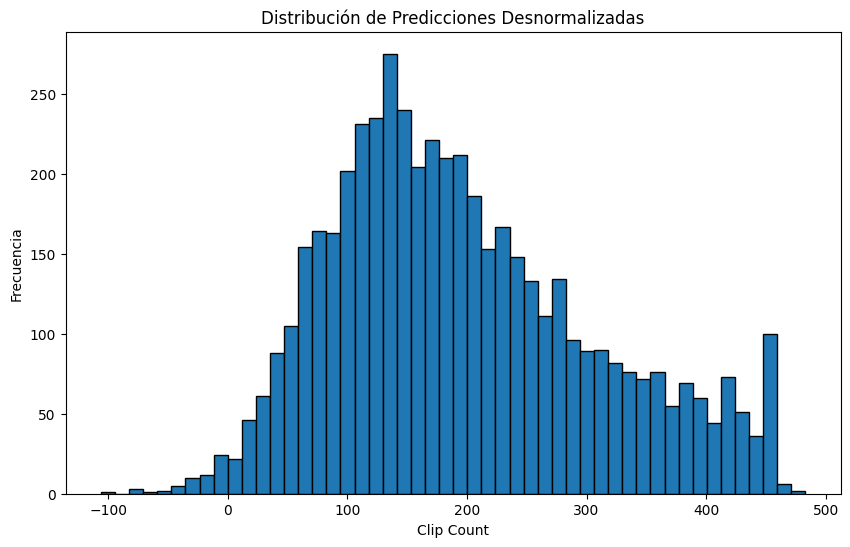

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_test['clip_count'], bins=50, edgecolor='black')
plt.title('Distribución de Predicciones Desnormalizadas')
plt.xlabel('Clip Count')
plt.ylabel('Frecuencia')
plt.show()
